<a href="https://colab.research.google.com/github/Queueriosity/Nernst/blob/main/Cannonball%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install 'openmdao[all]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 45.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.1/298.1 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 38.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 30.9 

In [2]:
import openmdao.api as om
import numpy as np

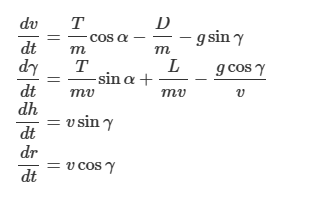

In [3]:
class FlightPathEOM2D(om.ExplicitComponent):
  """
    This class computes the values of velocity and position of the flight path using the given equations of motion
  """
  def initialize(self):
    self.options.declare('num_modes',types = int) #Idk what this line is for tbh

  def setup(self):
    self.add_input(name='m',val=1.0,units='kg',desc='mass of aircraft')
    self.add_input(name='v',val=1.0,units='m/s',desc='aircraft velocity magnitude')
    self.add_input(name='T',val=0.0,units='N',desc='thrust')
    self.add_input(name='alpha',val=0.0,units='rad',desc='angle of attack')
    self.add_input(name='L',val=0.0,units='N',desc='Lift force')
    self.add_input(name='D',val=0.0,units='N',desc='Drag Force')
    self.add_input(name='gam',val=0.0,units='rad',desc='Flight Path Angle(FPA)')

    self.add_output(name='v_dot',val=0.0,units='m/s**2',desc='velocity gradient')
    self.add_output(name='gam_dot',val=0.0,units='rad/s',desc='rate of change of FPA')
    self.add_output(name='h_dot',val=0.0,units='m/s',desc='Rate of change of altitude')
    self.add_output(name='r_dot',val=0.0,units='m/s',desc='rate of change of range')

  def setup_partials(self):
    self.declare_partials('v_dot',['T','m','alpha','gam','D'])
    self.declare_partials('gam_dot', ['T', 'L', 'm', 'gam', 'alpha', 'v'])
    self.declare_partials(['h_dot','r_dot'],['v','gam'])

  def compute(self,inputs,outputs):
    g = 9.80665
    m = inputs['m']
    T = inputs['T']
    v = inputs['v']
    alpha = inputs['alpha']
    L = inputs['L']
    D = inputs['D']
    gam = inputs['gam']

    calpha = np.cos(alpha) #Creating new variables to help us ease out the calculation of derivatives to find output
    salpha = np.sin(alpha)

    cgam = np.cos(gam)
    sgam = np.sin(gam)

    mv = m*v #For the sake of simplification

    outputs['v_dot'] = (T*calpha / m) - (D/m) - (g*salpha)
    outputs['gam_dot'] = (T*salpha / mv) + (L/mv) - (g*calpha/v)
    outputs['h_dot'] = v * sgam
    outputs['r_dot'] = v * cgam


Now to calculate the lift, The drag and their respective coefficients.

In [4]:
class DynamicPressureComp(om.ExplicitComponent):
  def setup(self):
    self.add_input(name='rho',val=1.0,units='kg/m**3',desc='atmospheric density')
    self.add_input(name='v',val=1.0,units='m/s',desc='air-relative velocity')

    self.add_output(name='q',val=1.0,units='N/m**2',desc='Dynamic Pressure')

    self.declare_partials(of='q',wrt='rho')
    self.declare_partials(of='q',wrt='v')
    """
    My guess is that when were not using a seperate function to declare partials,
    that is when we use this respective variant of the declare partials syntax, where "of" and "wrt" come into play
    """

  def compute(self,inputs,outputs):
    outputs['q'] = 0.5 * inputs['rho'] * inputs['v']**2
    """
      Basically implementing the method of list comprehension i guess (condensing all lines of code into 1)
    """

In [5]:
class LiftDragForce(om.ExplicitComponent):
  def initialise(self):
    self.options.declare('num_modes',types=int)


  def setup(self):
    self.add_input(name='CL',val=0.0,desc='Lift Coefficient')
    self.add_input(name='CD',val=0.0,desc='Drag Coefficient')
    self.add_input(name='q',val=0.0,units='N/m**2',desc='Dynamic Pressure')
    self.add_input(name='S',val=0.0,units='m**2',desc='Aerodynamic Reference Area')

    self.add_output(name='f_lift',shape=(1, ),units='N',desc='Aerodynamic Lift Force')
    self.add_output(name='f_drag',shape=(1, ),units='N',desc='Aerodynamic Drag Force')

    self.declare_partials(of='f_lift',wrt=['q','S','CL'])
    self.declare_partials(of='f_drag',wrt=['q','S','CD'])


  def compute(self,inputs,outputs):
    q = inputs['q']
    S = inputs['S']
    CL = inputs['CL']
    CD = inputs['CD']

    qS = q*S

    outputs['f_lift'] = qS * CL
    outputs['f_drag'] = qS * CD

In [11]:
class CannonballODE(om.Group):
  def setup(self):
    self.add_subsystem(name='dynamic_pressure',subsys=DynamicPressureComp(),promotes=['*'])
    self.add_subsystem(name='aero',subsys=LiftDragForce(),promotes_inputs=['*'])
    self.add_subsystem(name='eom',subsys=FlightPathEOM2D(),promotes=['*'])

    self.connect('aero.f_drag','D')
    self.connect('aero.f_lift','L')


To calculate the range, given the initial flight path angle and velocity, we use the Euler Integration method by predefining a time step ( First order method)


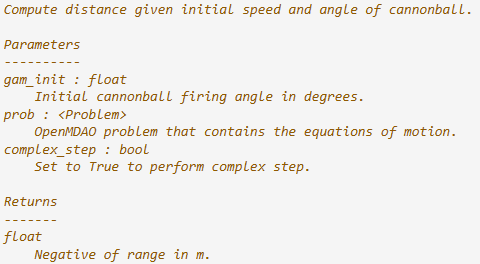

In [13]:
from scipy.optimize import minimize

def eval_cannonball_range(gam_init,prob,complex_step = False):
  dt = 0.1 #Time step
  h_init = 1.0 #Height of Cannon
  v_init = 100.0 #Initial Velocity of cannon ball
  h_target = 0.0 #Final height of cannonball

  v = v_init
  gam = gam_init
  h = h_init
  r = 0.0
  t = 0.0

  if complex_step:
    prob.set_complex_step_mode(True)

  while h > h_target:
    #Setting values
    prob.set_val('v',v)
    prob.set_val('gam',gam,units='deg')

    #Run the model
    prob.run_model()

    #Extracting the rates
    v_dot = prob.get_val('v_dot')
    gam_dot = prob.get_val('gam_dot',units='deg/s')
    h_dot = prob.get_val('h_dot')
    r_dot = prob.get_val('r_dot')

    h_last = h
    r_last = r

    #Euler Integration
    v = v + (dt * v_dot)
    gam = gam + (dt * gam_dot)
    h = h + (dt * h_dot)
    r = r + (dt * r_dot)
    t += dt
    #print(v,gam,h,r,t)

  #Linear Interpolation b/w last 2 points to get an accurate landign point
  r_final = r_last + (r - r_last) * h_last / (h_last - h)

  if complex_step:
    prob.set_complex_step_mode(False)

  print(f"Distance: {r_final}, Time: {t}, Angle: {gam_init}")
  return -r_final


def gradient_cannonball_range(gam_init, prob):
  """
  Uses complex step to compute gradient of range wrt initial angle.

  Parameters
    ----------
    gam_init : float
        Initial cannonball firing angle in degrees.
    prob : <Problem>
        OpenMDAO problem that contains the equations of motion.

    Returns
    -------
    float
        Derivative of range wrt initial angle in m/deg.
    """
  step = 1.0e-14
  dr_dgam = eval_cannonball_range(gam_init + step * 1j, prob, complex_step=True)
  return dr_dgam.imag / step

prob = om.Problem(model=CannonballODE())
prob.setup(force_alloc_complex=True)

# Set constants
prob.set_val('CL', 0.0)                          # Lift Coefficient
prob.set_val('CD', 0.05)                         # Drag Coefficient
prob.set_val('S', 0.25 * np.pi, units='ft**2')   # Wetted Area (1 ft diameter ball)
prob.set_val('rho', 1.225)                       # Atmospheric Density
prob.set_val('m', 5.5)                           # Cannonball Mass

prob.set_val('alpha', 0.0)                       # Angle of Attack (Not Applicable)
prob.set_val('T', 0.0)                           # Thrust (Not Applicable)

result = minimize(eval_cannonball_range, 27.0,method='SLSQP',jac=gradient_cannonball_range,args=(prob))

print(result['x'])

Distance: [747.43410033], Time: 9.299999999999983, Angle: [27.]
Distance: [747.43410033+1.91525675e-13j], Time: 9.299999999999983, Angle: [27.+1.e-14j]
Distance: [1011.00149545], Time: 15.299999999999962, Angle: [46.15256753]
Distance: [1011.00149545+8.04362098e-14j], Time: 15.299999999999962, Angle: [46.15256753+1.e-14j]
Distance: [1059.0519581], Time: 19.80000000000001, Angle: [60.02030858]
Distance: [1059.0519581-1.56317174e-14j], Time: 19.80000000000001, Angle: [60.02030858+1.e-14j]
Distance: [1060.31201997], Time: 19.0, Angle: [57.76381554]
Distance: [1060.31201997+3.00753977e-15j], Time: 19.0, Angle: [57.76381554+1.e-14j]
Distance: [1060.36664613], Time: 19.1, Angle: [58.12791227]
Distance: [1060.36664613+9.7076543e-16j], Time: 19.1, Angle: [58.12791227+1.e-14j]
Distance: [1060.35407843], Time: 19.200000000000003, Angle: [58.30144771]
Distance: [1060.37186915], Time: 19.1, Angle: [58.1776067]
Distance: [1060.37186915+1.13128981e-15j], Time: 19.1, Angle: [58.1776067+1.e-14j]
Dista